# resnet18 baseline code

- 7조 이민준님 참고
- seed : 42
- pretrained model : se-resnet50
- loss : cross entropy
- optimizer : adam
- epoch: 5
- batch-size : 32
- data augmentation : y
- fc layer : relu&dropout(0.7)
- lr : 0.0001

## 라이브러리 임포트

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
import random
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

In [4]:
def seed_everything(seed):
    """
    동일한 조건으로 학습을 할 때, 동일한 결과를 얻기 위해 seed를 고정시킵니다.
    
    Args:
        seed: seed 정수값
    """
    torch.manual_seed(seed) # pytorch의 random seed 고정
    torch.cuda.manual_seed(seed) # GPU 에서 사용하는 난수 생성 시드 고정
    # torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True # CuDNN 부분고정
    torch.backends.cudnn.benchmark = False # CuDNN 부분고정
    np.random.seed(seed) # Numpy 부분
    random.seed(seed) # transforms에서 random 라이브러리를 사용하기 때문에 random 라이브러리를 불러서 고정

seed_everything(42)

## dataset 생성

In [5]:
def search(dirname, result):  # 하위목록의 모든 파일을 찾는 함수
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == '.':  # .으로 시작하는 파일명 거름
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1]  # 확장자 체크
                if ext:
                    result.append(full_filename)
    except PermissionError:
        pass

In [6]:
all_path = []
search(train_image_dir_path, all_path)

train 데이터의 디렉토리는 2700개로 각각의 7개의 이미지 파일을 곱한 갯수가 나옵니다.

In [7]:
len(all_path) # 2700*7

18900

In [8]:
all_path[:10]

['/opt/ml/input/data/train/images/003554_female_Asian_59/mask3.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask5.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask4.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask1.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/normal.jpg',
 '/opt/ml/input/data/train/images/003554_female_Asian_59/mask2.jpg',
 '/opt/ml/input/data/train/images/003845_female_Asian_56/mask3.jpg',
 '/opt/ml/input/data/train/images/003845_female_Asian_56/mask5.jpg',
 '/opt/ml/input/data/train/images/003845_female_Asian_56/incorrect_mask.jpg']

파일 확장자는 jpg, png, jpeg로 3종류가 있습니다.

In [9]:
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)  # jpg, png, jpeg

['.jpg', '.png', '.jpeg']


In [10]:
all_path = sorted(all_path)
all_path[:10]

['/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask5.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask1.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask2.jpg']

라벨링 하는 함수입니다. 조건에 따라 숫자로 라벨을 부여합니다.

In [11]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    if gender == 'female':
        label += 3
    
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
    
    return label

path, label을 컬럼으로 갖는 dataframe을 생성해줍니다.

In [12]:
train_df = pd.DataFrame(all_path, columns = ['path'])

train_df['label'] = train_df['path'].map(lambda x : labeling(x))
train_df

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
    
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.X)

In [15]:
# transform = transforms.Compose([
#     Resize((512, 384), Image.BILINEAR),
#     ToTensor(),
#     Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
# ])

In [16]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

train, valid 나누는 파트입니다.
label의 비율을 유지하면서 나눴습니다.

In [17]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size=0.2,
                               shuffle=True, stratify=train_df['label'],
                               random_state=42)

In [18]:
train.shape, valid.shape

((15120, 2), (3780, 2))

### batch size

In [19]:
BATCH_SIZE = 32

## dataloader 설정

In [20]:
train_dataset = CustomDataset(train, data_transforms['train'])
train_dataloader = DataLoader(train_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle=True)

valid_dataset = CustomDataset(valid, data_transforms['val'])
valid_dataloader = DataLoader(valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

dataloader는 [batchsize, channel, height, wide]를 출력해줍니다.

In [21]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 3, 224, 224])

## 모델

In [22]:
# !pip3 install ipywidgets

In [23]:
# pip install --upgrade jupyter_client

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
# !pip install timm

### 모델 불러오기

In [26]:
import timm
se50 = timm.create_model('seresnet50', pretrained=True)

### fc 레이어 수정

> relu, dropout 추가

In [27]:
se50.fc = nn.Sequential(
               nn.Linear(2048, 512),
               nn.ReLU(inplace=True),
               nn.Dropout(0.7),
               nn.Linear(512, 512),
               nn.ReLU(inplace=True),
               nn.Dropout(0.7),
               nn.Linear(512, 18)).to(device)

In [28]:
se50.fc[6].weight.size(1)

512

In [29]:
import math

OUTPUT_CLASS_NUM = 18

# xavier uniform
torch.nn.init.xavier_uniform_(se50.fc[6].weight)
stdv = 1. / math.sqrt(se50.fc[6].weight.size(1))
se50.fc[6].bias.data.uniform_(-stdv, stdv)
se50.fc[6].weight.shape[0]

18

## loss, optimizer 설정

In [30]:
se50.to(device)

LEARNING_RATE = 0.0001  # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5  # 학습 때 mnist train 데이터셋을 얼마나 많이 학습할 지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss()  # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용
optimizer = torch.optim.Adam(se50.parameters(), lr=LEARNING_RATE)  # weight업데이트를 위한 optimizer를 Adam으로 사용

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

## 학습

In [31]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            se50.train()  # 네트워크 모델을 train 모드로 두어 gradient를 계산하고, 여러 sub module(배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            se50.eval()  # 네트워크 모델을 eval 모드로 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # parameter gradient 업데이터 전 초기화함
            
            with torch.set_grad_enabled(phase == "train"):  # train 모드 땐 gradient계산, 아닐 땐 gradient계산 안함으로써 연산량 줄임
                logits = se50(images)
                _, preds = torch.max(logits, 1)  # 모델에서 linear하게 나오는 예측값 리스트에서 최대 output index를 찾아 예측 레이블로 변경함
                loss = loss_fn(logits, labels)
                
                if phase == "train":
                    loss.backward()  # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step()  # 계산된 gradient를 가지고 모델 업데이트
            
            running_loss += loss.item() * images.size(0) # 한 batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 batch에서의 acc 값 저장
            
        # 한 epoch이 모두 종료되었을 때
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        print(f"현재 epoch-{epoch}의 {phase}-데이터셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best acc 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때 best loss 계산
            best_test_loss = epoch_loss

print("학습 종료!")
print(f"best acc : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터셋에서 평균 Loss : 1.359, 평균 Accuracy : 0.578
현재 epoch-0의 test-데이터셋에서 평균 Loss : 0.465, 평균 Accuracy : 0.864
현재 epoch-1의 train-데이터셋에서 평균 Loss : 0.496, 평균 Accuracy : 0.857
현재 epoch-1의 test-데이터셋에서 평균 Loss : 0.313, 평균 Accuracy : 0.900
현재 epoch-2의 train-데이터셋에서 평균 Loss : 0.309, 평균 Accuracy : 0.909
현재 epoch-2의 test-데이터셋에서 평균 Loss : 0.210, 평균 Accuracy : 0.933
현재 epoch-3의 train-데이터셋에서 평균 Loss : 0.220, 평균 Accuracy : 0.935
현재 epoch-3의 test-데이터셋에서 평균 Loss : 0.167, 평균 Accuracy : 0.949
현재 epoch-4의 train-데이터셋에서 평균 Loss : 0.156, 평균 Accuracy : 0.955
현재 epoch-4의 test-데이터셋에서 평균 Loss : 0.108, 평균 Accuracy : 0.969
학습 종료!
best acc : 0.9687830805778503, 최고 낮은 loss : 0.10770782589833572


## 검증

In [32]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1)  # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_acc = (n_correct/n_total)
        #model_train()
    return val_acc

In [33]:
func_eval(se50, valid_dataloader, device)

0.9687830687830687

In [34]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)
            
            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [35]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle=False)

check_eval_df = check_eval(valid, valid_testing_dataloader, se50, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/001151_male_As...,0,0
1,/opt/ml/input/data/train/images/000741_female_...,4,4
2,/opt/ml/input/data/train/images/004432_male_As...,3,1
3,/opt/ml/input/data/train/images/001574_female_...,4,4
4,/opt/ml/input/data/train/images/004230_female_...,5,5
...,...,...,...
3775,/opt/ml/input/data/train/images/001495-1_male_...,6,6
3776,/opt/ml/input/data/train/images/000041_female_...,16,16
3777,/opt/ml/input/data/train/images/003892_female_...,10,10
3778,/opt/ml/input/data/train/images/001538_male_As...,1,1


* 잘못 예측한 데이터 리스팅

In [36]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/004432_male_As...,3,1
1,/opt/ml/input/data/train/images/004432_male_As...,4,1
2,/opt/ml/input/data/train/images/001099_male_As...,1,0
3,/opt/ml/input/data/train/images/005435_female_...,13,15
4,/opt/ml/input/data/train/images/001632_female_...,11,10
...,...,...,...
113,/opt/ml/input/data/train/images/001175_male_As...,7,8
114,/opt/ml/input/data/train/images/003889_female_...,15,16
115,/opt/ml/input/data/train/images/001095_male_As...,13,12
116,/opt/ml/input/data/train/images/005508_female_...,5,4


## f1 score 측정

In [39]:
# !pip install seaborn

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

### 함수 정의

> precision, recall, f1-score, confusion matrix 출력

In [41]:
def report():
    y_test, y_pred = check_eval_df['target'], check_eval_df['pred']
    print(classification_report(y_test, y_pred))
    print('seresnet50 Accuracy:', np.mean(y_pred == y_test))
    ax = plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, fmt='.1f', annot=True)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       549
           1       0.96      0.99      0.97       410
           2       1.00      0.89      0.94        83
           3       0.98      1.00      0.99       732
           4       0.99      0.97      0.98       817
           5       0.84      0.99      0.91       109
           6       0.94      0.97      0.96       110
           7       0.91      0.99      0.95        82
           8       0.94      0.88      0.91        17
           9       0.99      0.95      0.97       146
          10       0.99      0.97      0.98       163
          11       0.90      0.86      0.88        22
          12       1.00      0.93      0.96       110
          13       0.79      1.00      0.88        82
          14       1.00      0.88      0.94        17
          15       0.98      0.92      0.95       146
          16       0.94      0.90      0.92       163
          17       0.83    

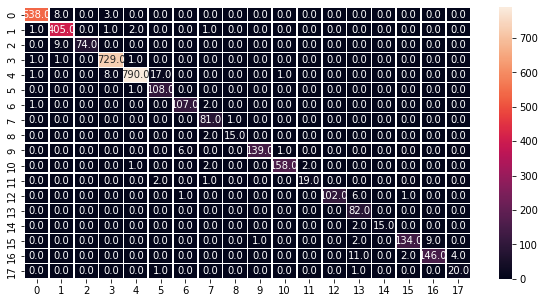

In [42]:
report()

## submission

In [44]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [45]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = se50.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission10-se50-dropout7-bs32.csv'), index=False)
print('test inference is done!')

test inference is done!


## 결과

* 실제 제출 시 성능 차이 매우 큼.
    * 검증 시 f1 score: 0.94
    * 제출 시 f1 score: 0.54
